# Tracking Machine Learning Experiments in Python with MLflow

As the climate changes, predicting the weather becomes ever more important for businesses. Since the weather depends on a lot of different factors, we want to run a lot of experiments to determine what the best approach is to predict the weather.

- In this project, we will use London Weather data sourced from [Kaggle](https://www.kaggle.com/datasets/emmanuelfwerr/london-weather-data) to try and predict the temperature.
- The focus of this code-along is running machine learning experiments. We will first do some minor exploratory data analysis, and then use `MLflow` to run experiments on what models and what hyperparameters to use.
- This is interesting for those of you that have already trained a machine learning model before and want to see how you can speed up the process of finding the best model.

In [74]:
!pip install mlflow

Defaulting to user installation because normal site-packages is not writeable


After the installation, we can import all the libraries, including MLflow. 

- `pandas` to import and read, and edit the data
- `numpy` is used for calculations. 
- `MLflow` is the library we'll use for structuring our machine learning experiments
- `seaborn` is used for visualizations
- `sklearn`, scikit-learn is used for machine learning, with functions such as data preprocessing, model training and prediction

In [12]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### Load data
We will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

We'll load the dataset using the pandas `read_csv` function.

In [77]:
# load dataset
df = pd.read_csv("london_weather.csv")

# show first 5 rows
df.head()


,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [50]:
# show info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


### Exploratory Data Analysis
Now that we have loaded the dataset, let's perform some exploratory data analysis to understand the data better. This includes handling missing values, feature engineering, and visualizing the data.

- Use pandas `pd.to_datetime` function to adjust the type of the date column
- Also add the year and month 
- Calculate the number of missing values using pandas `isna()`
- Select the relevant weather columns
- Groupby year and month and calculate the mean of the relevant metrics
- Lineplot the mean temperature per month using `seaborn`
- Barplot the mean sunshine per month
- Visualize a heatmap to show the correlation of features using seaborn's `heatmap()` function and pandas `.corr()` function.

In [78]:
# Converting 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# Check missing values
df.isna().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

<AxesSubplot: xlabel='year', ylabel='mean_temp'>

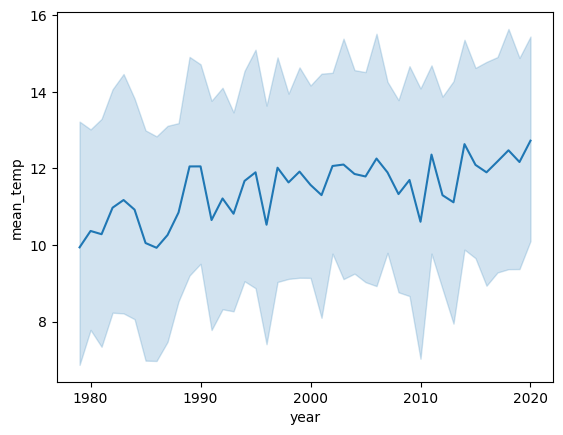

In [79]:
# Grouping data by year and month, calculating mean of weather metrics
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

df_month = df.groupby(['year', 'month'], as_index=False).mean()

# Visualizing mean temperature
sns.lineplot(x="year", y='mean_temp', data=df_month)

<AxesSubplot: xlabel='month', ylabel='sunshine'>

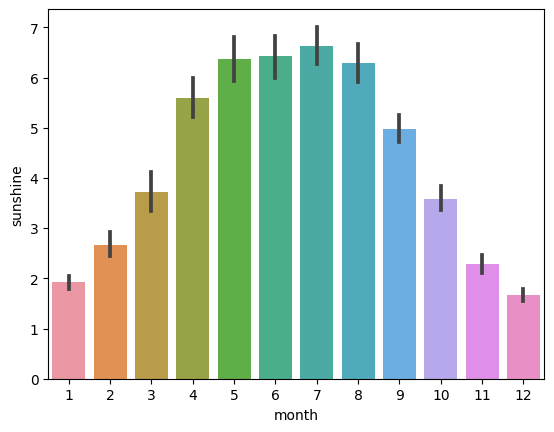

In [80]:
# Visualizing mean sunshine
sns.barplot(x='month', y='sunshine', data=df_month)

<AxesSubplot: >

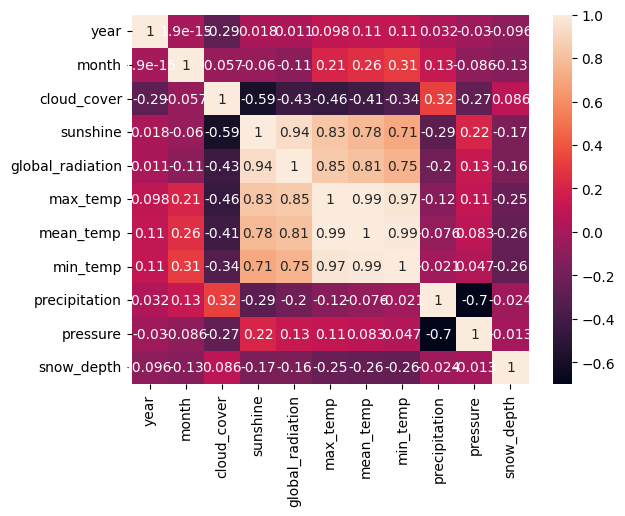

In [81]:
# Visualizing heatmap of correlation
sns.heatmap(df_month.corr(), annot=True)

### Process data into train and test sets
Next, we have a function to preprocess the dataframe into train and test samples. 
- In this function we impute and scale the features. Imputing is done to fill in missing values, in this case using the mean, and scaling is used to put all features on the same scale, which often improves the performance.
- Important to note is that we split the train and test set before we do imputation and scaling, such that there is no data leakage between train and test set.
- Before running the function, we will also drop rows in which the temperature variable is unknown. Since we need to be able to train and test on the target variable at all times.

In [82]:
selected_cols = ["cloud_cover", "sunshine", "global_radiation", "snow_depth",
                 "month", "mean_temp" ]   
df_1 = df[selected_cols]

In [55]:
df_1

,cloud_cover,sunshine,global_radiation,snow_depth,month,mean_temp
0,2.0,7.0,52.0,9.0,1,-4.1
1,6.0,1.7,27.0,8.0,1,-2.6
2,5.0,0.0,13.0,4.0,1,-2.8
3,8.0,0.0,13.0,2.0,1,-2.6
4,6.0,2.0,29.0,1.0,1,-0.8
...,...,...,...,...,...,...
15336,1.0,0.9,32.0,NaN,12,7.5
15337,7.0,3.7,38.0,NaN,12,1.1
15338,7.0,0.0,21.0,NaN,12,2.6
15339,6.0,0.4,22.0,NaN,12,2.7


In [83]:
def preprocess_df(df, features, target_var):
    df = df.dropna(subset=[target_var])
    X = df[features]    
    y = df[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
    
    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_test  = imputer.transform(X_test)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

features = selected_cols
target_var = 'mean_temp'
X_train, X_test, y_train, y_test = preprocess_df(df, features, target_var)

### Running a machine learning experiment
Now we will move on to the bulk of this code-along, namely, running machine learning experiments. A simple example of training a machine learning model would go as follows:


`lreg = LinearRegression().fit(X_train, y_train)`

`y_pred = lreg.predict(x_test)`

`rmse = np.sqrt(mean_squared_error(y_test, y_pred))`


We train a linear regression model, predict the target variable and calculate the score of the model. Repeating this for different settings, and possibly another model would result in a lot of duplicate code. You could write functions to repeatedly go over different models and hyperparameters, but you can also use MLflow. MLflow allows you to run different experiments, log the experiments, and also save the model with the best result. Since we are limited to the workspaces, we focus on tracking and logging experiments in this project.

In [91]:
mlflow.set_experiment('example_experiment_1')

for i in range(4):
    with mlflow.start_run():
        model = DecisionTreeRegressor()
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Calculate RMSE
        mse = mean_squared_error(y_test, y_pred, squared=False)

        # Log hyperparameters and metrics
        mlflow.set_tag("model", "decision tree")
        mlflow.log_metric("mse", mse)

        # Save the model
        mlflow.sklearn.log_model(model, "model")
    
mlflow.search_runs(experiment_ids=[mlflow.get_experiment_by_name('example_experiment_1').experiment_id])

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mse,tags.model,tags.mlflow.log-model.history,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.user
0,f4978a0950214d228e5da7f37bb2ef13,950013570032453960,FINISHED,file:///work/files/workspace/mlruns/9500135700...,2023-11-21 15:20:45.894000+00:00,2023-11-21 15:20:48.254000+00:00,0.031200,decision tree,"[{""run_id"": ""f4978a0950214d228e5da7f37bb2ef13""...",/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,fortunate-chimp-214,repl
1,6b40974d6fed4b9289c266649ba3349c,950013570032453960,FINISHED,file:///work/files/workspace/mlruns/9500135700...,2023-11-21 15:20:43.325000+00:00,2023-11-21 15:20:45.871000+00:00,0.019297,decision tree,"[{""run_id"": ""6b40974d6fed4b9289c266649ba3349c""...",/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,angry-shark-959,repl
2,3d64f13ea195416080f60b9eb7163194,950013570032453960,FINISHED,file:///work/files/workspace/mlruns/9500135700...,2023-11-21 15:20:40.923000+00:00,2023-11-21 15:20:43.299000+00:00,0.030099,decision tree,"[{""run_id"": ""3d64f13ea195416080f60b9eb7163194""...",/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,monumental-vole-838,repl
3,55b0b98cf6e74cccbb5fad64a8b8db4e,950013570032453960,FINISHED,file:///work/files/workspace/mlruns/9500135700...,2023-11-21 15:20:38.497000+00:00,2023-11-21 15:20:40.903000+00:00,0.018841,decision tree,"[{""run_id"": ""55b0b98cf6e74cccbb5fad64a8b8db4e""...",/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,ambitious-cod-306,repl


### Predicting the temperature in London
We will now do this for the london weather dataset. We will use two different regression models, decision tree regression, and random forest regression. We will start with just using the depth as a parameter to experiment with.

- Start by declaring an `EXPERIMENT_NAME` and `EXPERIMENT_ID`, and use the `create_experiment()` function of MLflow to create an experiment.
- Then create a `for`-loop to go over different `depth` values
- Declare a parameters dictionary that takes the depth value from the loop. Include a `random_state` to make sure we can re-run the experiment and get similar results.
- Use MLflow's `start_run()`, include the `experiment_id` and `run_name` in the function call.
- Fit the `DecisionTreeRegressor()` and `RandomForestRegressor()` to the training data.
- Get the RMSE of each model and log the parameters and metrics using MLflow's `log_param()` and `log_metric()` functions. 
- Save the experiment results using MLflow `search_runs()` function.

In [92]:
# Define experiment name
experiment_name = 'Temp_Regression_v1'
experiment_ID = mlflow.create_experiment(experiment_name)

# Setup for loop
for idx, depth in enumerate(range(1,20, 4)):
    params = {'max_depth': depth, 'random_state': 1}
    run_name = f"run_{idx}"
    
    with mlflow.start_run(experiment_id=experiment_ID, run_name=run_name):
        D_reg = DecisionTreeRegressor(**params).fit(X_train, y_train)
        R_reg = RandomForestRegressor(**params).fit(X_train, y_train)
        
        D_predicted = D_reg.predict(X_test)
        F_predicted = R_reg.predict(X_test)
        
        D_reg_rscore = r2_score(y_test, D_predicted)
        F_reg_rscore = r2_score(y_test, F_predicted)
        
        mlflow.log_param("max_depth", depth)
        mlflow.log_metric("D_reg_rscore", D_reg_rscore)
        mlflow.log_metric("F_reg_rscore", F_reg_rscore)
        

# Save experiment results
# ...

In [93]:
mlflow.search_runs(experiment_names=["Temp_Regression_v1"])

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.D_reg_rscore,metrics.F_reg_rscore,params.max_depth,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.user
0,27ba15808251457cb768f1b551846942,536207023257878430,FINISHED,file:///work/files/workspace/mlruns/5362070232...,2023-11-21 15:21:31.857000+00:00,2023-11-21 15:21:33.447000+00:00,0.999968,0.999995,17,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,run_4,repl
1,4ec70acdd18647c190de0697d308d02a,536207023257878430,FINISHED,file:///work/files/workspace/mlruns/5362070232...,2023-11-21 15:21:30.235000+00:00,2023-11-21 15:21:31.836000+00:00,0.999972,0.999995,13,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,run_3,repl
2,8e39d0a0cc6d40c2a45a0efc4ae53dfd,536207023257878430,FINISHED,file:///work/files/workspace/mlruns/5362070232...,2023-11-21 15:21:28.661000+00:00,2023-11-21 15:21:30.213000+00:00,0.999966,0.999994,9,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,run_2,repl
3,257d04a242a9446e9f3d266d1bdf5273,536207023257878430,FINISHED,file:///work/files/workspace/mlruns/5362070232...,2023-11-21 15:21:27.532000+00:00,2023-11-21 15:21:28.639000+00:00,0.997846,0.999055,5,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,run_1,repl
4,7059cfd853854fd2bc3dc50cc2fd8799,536207023257878430,FINISHED,file:///work/files/workspace/mlruns/5362070232...,2023-11-21 15:21:26.962000+00:00,2023-11-21 15:21:27.510000+00:00,0.697314,0.704014,1,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,run_0,repl
